<a href="https://colab.research.google.com/github/dangdang2222/frankmocap_project/blob/main/camera_coordinate_to_world_coordinate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install numpy-quaternion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 8.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for numpy-quaternion: filename=numpy_quaternion-2022.4.2-cp37-cp37m-linux_x86_64.whl size=158432 sha256=b9c8933ab4243ebc04470c580be5bdca61cb38c5fb0dce677fb1aed3b42b5bb3
  Stored in directory: /root/.cache/pip/wheels/ce/dc/f3/1b4a5e49b5590eec6fe35cc44fce61b37f599dd67468472075
Successfully built numpy-quaternion


# camera_pose_visualizer

In [60]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(6.4*2, 4.8*2))
        #self.ax = self.fig.gca(projection='3d')
        self.ax = self.fig.add_subplot(projection='3d')
        self.ax.set_aspect("auto")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        print(vertex_std)
        print(extrinsic.T)
        vertex_transformed = vertex_std @ extrinsic.T
        print(vertex_transformed)
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        print(meshes)
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

# camera_parameter_loader

In [61]:
import json
import os
import numpy as np
import quaternion

class CameraParameterLoader:
    def __init__(self):
        print('initialize camera parameter lodaer')

    def get_intrinsic(self, path):
        with open(os.path.join(path, '_camera_settings.json'), 'r') as f:
            param_cam = json.load(f)
            param_intrinsic = param_cam['camera_settings'][0]['intrinsic_settings']
            cx = param_intrinsic['cx']
            cy = param_intrinsic['cy']
            fx = param_intrinsic['fx']
            fy = param_intrinsic['fy']
            s = param_intrinsic['s']
            mat_intrinsic = np.array([[fx, s, cx],
                                      [0, fy, cy],
                                      [0, 0, 1]])
        return mat_intrinsic

    def get_extrinsic(self, path):
        with open(path, 'r') as f:
            param_cam = json.load(f)['camera_data']
            param_translation = param_cam['location_worldframe']
            param_rotation = param_cam['quaternion_xyzw_worldframe']

            mat_rotation = quaternion.as_rotation_matrix(
                np.quaternion(param_rotation[3], param_rotation[0], param_rotation[1], param_rotation[2]))
            print(np.quaternion(param_rotation[3], param_rotation[0], param_rotation[1], param_rotation[2]))
            print(mat_rotation)
            mat_translation = np.array([[param_translation[0]], [param_translation[1]], [param_translation[2]]])
            print(mat_translation)
            mat_extrinsic = np.concatenate(
                [np.concatenate([mat_rotation, mat_translation], axis=1), np.array([[0, 0, 0, 1]])], axis=0)
            print(mat_extrinsic)
            return mat_extrinsic

# demo1

initialize camera pose visualizer
[[ 0.  0.  0.  1.]
 [ 3. -3. 10.  1.]
 [ 3.  3. 10.  1.]
 [-3.  3. 10.  1.]
 [-3. -3. 10.  1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.  0.  0.  1.]
 [ 3. -3. 10.  1.]
 [ 3.  3. 10.  1.]
 [-3.  3. 10.  1.]
 [-3. -3. 10.  1.]]
[[array([0., 0., 0.]), array([ 3., -3., 10.]), array([ 3.,  3., 10.])], [array([0., 0., 0.]), array([ 3.,  3., 10.]), array([-3.,  3., 10.])], [array([0., 0., 0.]), array([-3.,  3., 10.]), array([-3., -3., 10.])], [array([0., 0., 0.]), array([-3., -3., 10.]), array([ 3., -3., 10.])], [array([ 3., -3., 10.]), array([ 3.,  3., 10.]), array([-3.,  3., 10.]), array([-3., -3., 10.])]]


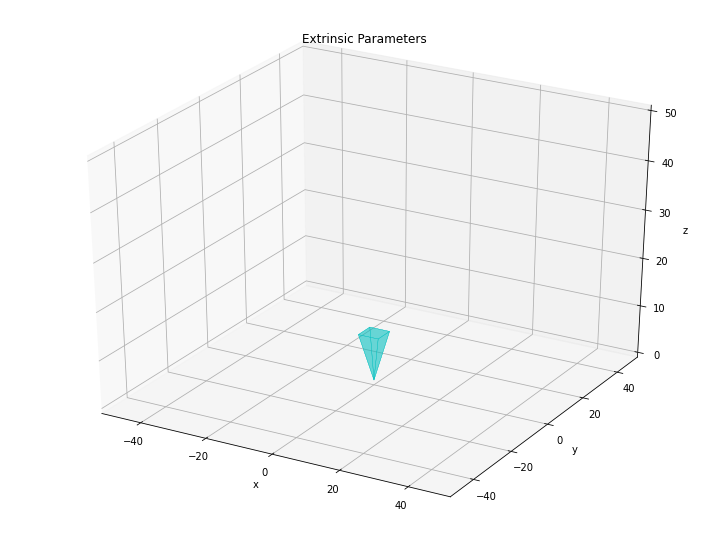

In [63]:
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 50])
visualizer.extrinsic2pyramid(np.eye(4), 'c', 10)
visualizer.show()

# demo2

In [28]:
import os
import glob

In [103]:
np.set_printoptions(precision=10)

initialize camera parameter lodaer
[[3663.46     812.1762  2322.1646 ]
 [3138.4949   931.0773  2249.541  ]
 [3264.0654   940.7142  1977.2559 ]
 [3282.2693   641.27515 1975.053  ]
 [3156.6985   631.63824 2247.3381 ]]
[[3.6634599609e+03 8.1217620850e+02 2.3221645508e+03 1.0000000000e+00]
 [3.1384948730e+03 9.3107727051e+02 2.2495410156e+03 1.0000000000e+00]
 [3.2640654297e+03 9.4071417236e+02 1.9772558594e+03 1.0000000000e+00]
 [3.2822692871e+03 6.4127514648e+02 1.9750529785e+03 1.0000000000e+00]
 [3.1566984863e+03 6.3163824463e+02 2.2473381348e+03 1.0000000000e+00]]
[[array([3663.4599609375,  812.1762084961, 2322.1645507812]), array([3138.4948730469,  931.0772705078, 2249.541015625 ]), array([3264.0654296875,  940.7141723633, 1977.255859375 ])], [array([3663.4599609375,  812.1762084961, 2322.1645507812]), array([3264.0654296875,  940.7141723633, 1977.255859375 ]), array([3282.2692871094,  641.2751464844, 1975.0529785156])], [array([3663.4599609375,  812.1762084961, 2322.1645507812]), ar

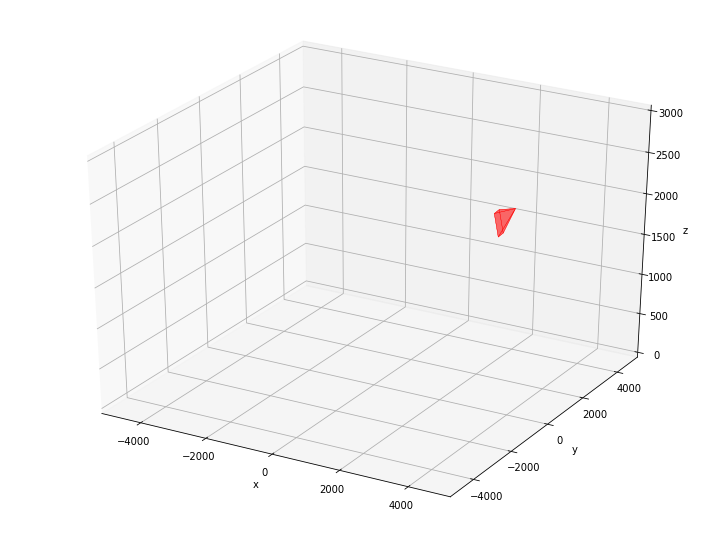

In [129]:
loader = CameraParameterLoader()
#visualizer = CameraPoseVisualizer([-5000, 5000], [-5000, 5000], [0, 3000])
list_name = '/content/drive/MyDrive/extrinsic2pyramid-main/dataset/000000.json'
world_position=[]
camera_positions = np.array([[0,0,0],[150,-150,500],[150,150,500],[-150,150,500],[-150,-150,500]],dtype= np.float32)
world_positions = np.array([[0,0,0],[150,-150,150],[150,150,150],[-150,150,500],[-150,-150,150]],dtype=np.float32)
mat_rot = np.array([[ -0.060679,0.998130,0.007343],[0.418569,0.032123,-0.907617],[-0.906156,-0.052000,-0.419735]])
mat_trans = np.array([[-605.413346],[548.137858],[4336.592638]])

for indx, i in enumerate(camera_positions):
  cam_position = np.array([[i[0]],[i[1]],[i[2]]])
  world_point = np.matrix(mat_rot.T)*(np.matrix(cam_position - mat_trans))

  world_positions[indx] = world_point.reshape(-1)
print(world_positions)
print(np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T)
f_world_positions = np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T
vertex_transformed = np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T
# mat_rotation = np.array([[ -0.060679,0.998130,0.007343],[0.418569,0.032123,-0.907617],[-0.906156,-0.052000,-0.419735]])
# mat_translation = np.array([[-605.413346],[548.137858],[4336.592638]])
# mat_extrinsic = np.concatenate([np.concatenate([mat_rotation, mat_translation], axis=1), np.array([[0, 0, 0, 1]])], axis=0)

# print(mat_extrinsic)
# #extrinsic = loader.get_extrinsic(list_name)
# visualizer.extrinsic2pyramid(mat_extrinsic, 'c', 500)
meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
print(meshes)
fig = plt.figure(figsize=(6.4*2, 4.8*2))
ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")
ax.set_xlim([-5000, 5000])
ax.set_ylim([-5000, 5000])
ax.set_zlim([0, 3000])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.add_collection3d(Poly3DCollection(meshes, facecolors='r', linewidths=0.3, edgecolors='r', alpha=0.35))
            

initialize camera parameter lodaer
[[3.6634599609e+03 8.1217620850e+02 2.3221645508e+03 1.0000000000e+00]
 [3.1384948730e+03 9.3107727051e+02 2.2495410156e+03 1.0000000000e+00]
 [3.2640654297e+03 9.4071417236e+02 1.9772558594e+03 1.0000000000e+00]
 [3.2822692871e+03 6.4127514648e+02 1.9750529785e+03 1.0000000000e+00]
 [3.1566984863e+03 6.3163824463e+02 2.2473381348e+03 1.0000000000e+00]]
[[-2.2500180664e+03  8.0686840820e+02  2.4080935059e+03  1.0000000000e+00]
 [-1.7454261475e+03  6.2301232910e+02  2.3269509277e+03  1.0000000000e+00]
 [-1.8750859375e+03  6.3125994873e+02  2.0565432129e+03  1.0000000000e+00]
 [-1.8552568359e+03  9.3060351562e+02  2.0561650391e+03  1.0000000000e+00]
 [-1.7255970459e+03  9.2235589600e+02  2.3265727539e+03  1.0000000000e+00]]
[[-2.2940266113e+03 -3.6410195312e+03  2.3605429688e+03  1.0000000000e+00]
 [-1.8576311035e+03 -3.3281994629e+03  2.2786743164e+03  1.0000000000e+00]
 [-1.9406533203e+03 -3.4271010742e+03  2.0078872070e+03  1.0000000000e+00]
 [-2.176

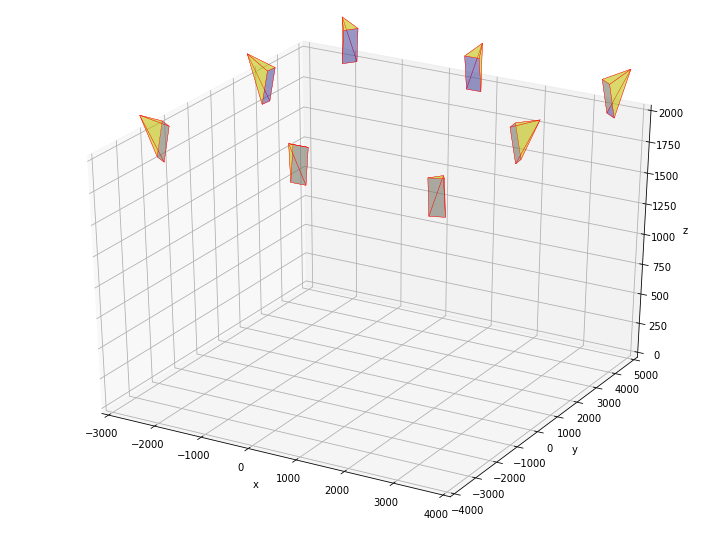

In [165]:
loader = CameraParameterLoader()
#visualizer = CameraPoseVisualizer([-5000, 5000], [-5000, 5000], [0, 10000])
list_name = '/content/drive/MyDrive/extrinsic2pyramid-main/dataset/000000.json'
world_position=[]
camera_positions = np.array([[0,0,0],[150,-150,500],[150,150,500],[-150,150,500],[-150,-150,500]],dtype= np.float32)
world_positions = np.array([[0,0,0],[150,-150,150],[150,150,150],[-150,150,500],[-150,-150,150]],dtype=np.float32)
mat_rots = np.array([[[ -0.060679,0.998130,0.007343],[0.418569,0.032123,-0.907617],[-0.906156,-0.052000,-0.419735]],
                    [[-0.066097,-0.997812,0.001260],[-0.432199,0.027492,-0.901359],[0.899353,-0.060121,-0.433071]],
                    [[ 0.784980,-0.619352,-0.014461],[-0.276741,-0.329672,-0.902624],[0.554275,0.712544,-0.430186 ]],
                    [[-0.999920,-0.012570,-0.001528],[-0.003610,0.398618,-0.917110],[0.012137,-0.917031,-0.398631]],
                    [[-0.733829,-0.677994,-0.042651],[-0.217095,0.293539,-0.930970],[0.643711,-0.673913,-0.362597]],
                    [[0.799458,0.600171,-0.025722],[0.247259,-0.367782,-0.896437],[-0.547476,0.710304,-0.442424 ]],
                    [[ -0.755252,0.655282, 0.014137],[0.279717,0.341747,-0.897200],[-0.592750,-0.673657,-0.441399]],
                    [[0.999871,0.015922,0.002158],[0.008548,-0.413380,-0.910518],[-0.013605,0.910419,-0.413463 ]]])
mat_transs = np.array([[[-605.413346],[548.137858],[4336.592638]],
                      [[653.352810],[1175.918886],[3114.943323]],
                      [[-420.172604],[295.490400],[4881.382220]],
                      [[ 728.642753],[7.551169],[5699.942529]],
                      [[ 1966.137295],[76.021013],[5872.706559]],
                      [[-704.819635],[-127.891999],[5625.110129]],
                      [[ -737.902102],[-790.877554],[6746.539080]],
                      [[-621.529759],[660.889110 ],[4254.063740 ]]])
fig = plt.figure(figsize=(6.4*2, 4.8*2))
ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")
ax.set_xlim([-3000, 4000])
ax.set_ylim([-4000, 5000])
ax.set_zlim([0, 2000])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
for mat_rot,mat_trans in zip(mat_rots,mat_transs):
  for indx, i in enumerate(camera_positions):
    cam_position = np.array([[i[0]],[i[1]],[i[2]]])
    world_point = np.matrix(mat_rot.T)*(np.matrix(cam_position - mat_trans))

    world_positions[indx] = world_point.reshape(-1)
  print(np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T)
  f_world_positions = np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T
  vertex_transformed = np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T
  meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                              [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                              [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                              [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                              [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
                           
  ax.add_collection3d(Poly3DCollection(meshes ,facecolors=['y','y','y','y','b'], linewidths=0.3, edgecolors='r', alpha=0.35))

In [ ]:
loader = CameraParameterLoader()
visualizer = CameraPoseVisualizer([-5000, 5000], [-5000, 5000], [0, 3000])
visualizer.extrinsic2pyramid(f_world_positions, 'c', 10)

In [125]:
print(world_positions)
print(world_positions.T)
print(np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0))
print(np.concatenate([world_positions.T, np.array([[1,1,1,1,1]])],axis=0).T)

[[3663.46     812.1762  2322.1646 ]
 [3455.6494   949.2773  2396.4482 ]
 [3581.2202   958.9142  2124.163  ]
 [3282.2693   641.27515 1975.053  ]
 [3473.853    649.83826 2394.2454 ]]
[[3663.46    3455.6494  3581.2202  3282.2693  3473.853  ]
 [ 812.1762   949.2773   958.9142   641.27515  649.83826]
 [2322.1646  2396.4482  2124.163   1975.053   2394.2454 ]]
[[3.6634599609e+03 3.4556494141e+03 3.5812202148e+03 3.2822692871e+03
  3.4738530273e+03]
 [8.1217620850e+02 9.4927728271e+02 9.5891418457e+02 6.4127514648e+02
  6.4983825684e+02]
 [2.3221645508e+03 2.3964482422e+03 2.1241630859e+03 1.9750529785e+03
  2.3942453613e+03]
 [1.0000000000e+00 1.0000000000e+00 1.0000000000e+00 1.0000000000e+00
  1.0000000000e+00]]
[[3.6634599609e+03 8.1217620850e+02 2.3221645508e+03 1.0000000000e+00]
 [3.4556494141e+03 9.4927728271e+02 2.3964482422e+03 1.0000000000e+00]
 [3.5812202148e+03 9.5891418457e+02 2.1241630859e+03 1.0000000000e+00]
 [3.2822692871e+03 6.4127514648e+02 1.9750529785e+03 1.0000000000e+00]

{
  "camera_data": {
    "location_worldframe": [
      -21.992471282223093, 
      -2.772151118213733, 
      95.4176069581549
    ], 
    "quaternion_xyzw_worldframe": [
      0.9520820213427617, 
      0.04072454550030966, 
      -0.0688625300668182, 
      -0.29519453208211693
    ]
  }

initialize camera parameter lodaer
initialize camera pose visualizer
quaternion(-0.295194532082117, 0.952082021342762, 0.0407245455003097, -0.0688625300668182)
[[ 0.98719893  0.03689051 -0.1551688 ]
 [ 0.11820184 -0.82240349  0.55648973]
 [-0.10708217 -0.56770731 -0.81623638]]
[[-21.99247128]
 [ -2.77215112]
 [ 95.41760696]]
[[ 9.87198933e-01  3.68905112e-02 -1.55168799e-01 -2.19924713e+01]
 [ 1.18201838e-01 -8.22403492e-01  5.56489732e-01 -2.77215112e+00]
 [-1.07082171e-01 -5.67707307e-01 -8.16236377e-01  9.54176070e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.  0.  0.  1.]
 [ 3. -3. 10.  1.]
 [ 3.  3. 10.  1.]
 [-3.  3. 10.  1.]
 [-3. -3. 10.  1.]]
[[ 9.87198933e-01  1.18201838e-01 -1.07082171e-01  0.00000000e+00]
 [ 3.68905112e-02 -8.22403492e-01 -5.67707307e-01  0.00000000e+00]
 [-1.55168799e-01  5.56489732e-01 -8.16236377e-01  0.00000000e+00]
 [-2.19924713e+01 -2.77215112e+00  9.54176070e+01  1.00000000e+00]]
[[-2.19924713e+01 -2.77215112e+00  9.54

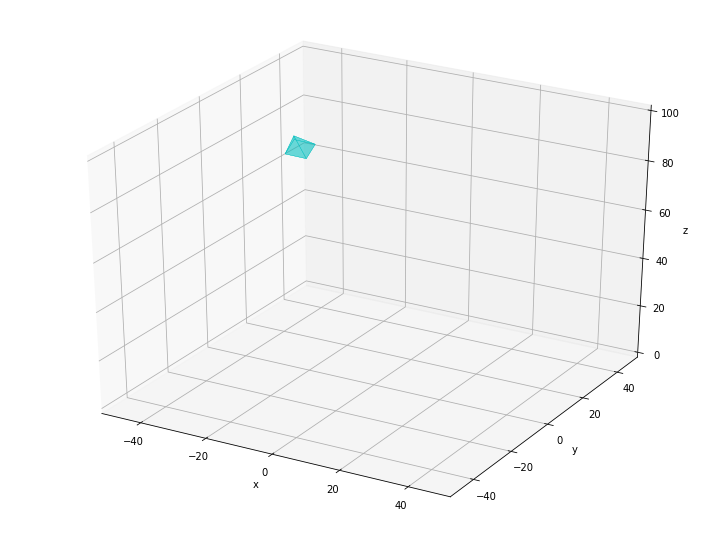

In [65]:
loader = CameraParameterLoader()
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 100])
list_name = '/content/drive/MyDrive/extrinsic2pyramid-main/dataset/000000.json'
extrinsic = loader.get_extrinsic(list_name)
visualizer.extrinsic2pyramid(extrinsic, 'c', 10)
